# Residential Building Classification
This is a bare-bone version of the residential vs. non-residential building classification. We use DenseNet in this implementation. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt

import params
from densenet_efficient import DenseNetEfficient
from solver import train, test_epoch
from dataset import *

# Load parameters
params = vars(params)
rbc_class_names = params['rbc_class_names']
fmow_class_names = params['fmow_class_names']
fmow_class_names_mini = params['fmow_class_names_mini']
dtype = params['dtype']

torch.set_num_threads(params['num_threads'])

## Preprocess FMOW Dataset
Check if fMoW dataset is available. If so, process the images by cropping based on given bounding boxes. Load in traing, validation and test dataset along with ground truth labels for training and validation set. 

In [2]:
mean = 0.5
stdv = 0.25
train_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
train_set = FMOWDataset(params, transform=train_transforms)
x,y = train_set[0]
print(type(x), x.shape, type(y), y.shape)

<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])


In [3]:
mean = 0.5
stdv = 0.25
train_transforms = transforms.Compose([
    Normalize(mean=mean, std=stdv),
    Rescale((224,224)),
    ToTensor(),
])
test_set = FMOWDataset_test(params, transform=train_transforms)
x,y = test_set[0]
print(type(x), x.shape, type(y), y.shape)

<class 'torch.FloatTensor'> torch.Size([1, 224, 224]) <class 'torch.LongTensor'> torch.Size([1])


In [4]:
# data_test = load_test(params, mean_image=None)
# X_test = data_test['X_test']
# y_test = data_test['y_test']
# X_test_tensor = torch.from_numpy(X_test)
# y_test_tensor = torch.from_numpy(y_test)
# test_data = TensorDataset(X_test_tensor, y_test_tensor)
# loader_test = DataLoader(test_data, batch_size=params['batch_size'], sampler=RandomSampler(X_test.shape[0]))
# print(X_test.shape, X_test.dtype)
# print(y_test.shape, y_test.dtype)
# print(y_test)

### Visualize a small batch of data
Plot a small batch of training images to get a sense of data

IndexError: list index out of range

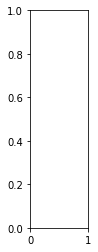

In [5]:
# Sample a minibatch and show the images and captions
size = 5
indices = np.random.choice(len(test_set), size, replace=False)

fig = plt.figure()

for i, idx in enumerate(indices):
    image, label = test_set[idx]
    plt.subplot(1, size, i + 1)
    plt.title(params['rbc_class_names'][label[0]])
    plt.axis('off')
    plt.imshow(image[0,:,:])
    plt.show()

## Load Model
Load in pre-trained DenseNet. Configure training parameters. 

### Naive two-layer CNN

In [10]:
model = DenseNetEfficient(
        growth_rate=32, 
        block_config=(6, 12, 24, 16), 
        compression=0.5,
        num_init_features=64, 
        bn_size=4, 
        drop_rate=0,
        num_classes=20, 
        small_inputs=False)
# Move model to GPU
model = model.cuda()
# print(model)


/home/feng/anaconda3/envs/rbc_env/lib/python3.6/site-packages/torch/nn/modules/container.py:13: UserWarning: nn.Container is deprecated. All of it's functionality is now implemented in nn.Module. Subclass that instead.
  warnings.warn("nn.Container is deprecated. All of it's functionality "


In [7]:
# Load an existing model
model.load_state_dict(torch.load('/home/feng/ext2/feng/workspace/residential_building_challenge/output/model.dat'))

## Train Model
Train the model one epoch at a time. Keep the verbose option on to monitor the loss during training. 
Save training and validation accuracy history for visualization. 

In [ ]:
[[ 45   7   1   0   2   5   4   0   0   0   1   2   2   4   0   1   2   0
    0   0]
 [  2  34   1   0   1   6   1   4   0   2   6   2   0   6   2   0   1   8
    0   0]
 [  1   1 101   0   2   3   4  13   0  12   1   3   3  12   5   5   2   3
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   3   2   0  19   0   1   1   0   7   0   0   1   0   0   0   2   0
    1   0]
 [  4   2   1   0   0  22   4   1   0   0   1   2   2  11   3   0   3   1
    0   0]
 [  3   3   1   0   2   2  95   2   0   8   2   2   7   6   3   0   0   1
    0   0]
 [  0   1   8   0   1   2   4  19   0   7   4   2   1   7   3   1   0   1
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  1   2   9   0   3   3   3   3   0 111   1   1   3   6   2   2   7   4
    0   0]
 [  1   0   2   0   0   1   3   8   0   3  44   5   4   9   3   0   0  14
    0   0]
 [  3   4   6   0   0   5   9   8   0   1   3  18   6   8   3   1   0   2
    0   0]
 [  1   4   6   0   2   2  12   5   0   7   3   0 123   4   6   1  12   3
    0   0]
 [  2   7  10   0   0  13   9  10   0   5   6   6   3 153   3   0   6   8
    0   0]
 [  0   3   4   0   0  12   4   5   0   4   4   8   2   9  14   0   0   3
    0   0]
 [  0   0   5   0   1   0   1   1   0   9   0   0   0   0   0  46   2   1
    0   0]
 [  2   0   3   0   0   1   1   0   0   4   1   3   8   5   0   0 315   2
    0   0]
 [  0   5   1   0   0   5   3   0   0   1  12   2   1  18   4   0   2  79
    0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
res detect 79 + 44 = 123
res total 133 + 97 = 230 

In [11]:
train(model, 
      train_set, 
      None, 
      '/home/feng/ext2/feng/workspace/residential_building_challenge/output', 
      n_epochs=40, 
      valid_size=2000,
      batch_size=64, 
      lr=0.1, 
      wd=0.0001, 
      momentum=0.9, 
      seed=None)

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:58

## Visualization
Visualize training and validation accuracy throughout training history. 
Visualize loss function. 

In [ ]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

with open(os.path.join('/home/feng/ext2/feng/workspace/residential_building_challenge/output', 'results.csv'), 'r') as f:
        for line in f:
            numbers = line.split(',')
            if(numbers[0]=='epoch'):
                continue
            try:
                train_loss.append(float(numbers[1]))
                train_acc.append(1-float(numbers[2]))
                valid_loss.append(float(numbers[3]))
                valid_acc.append(1-float(numbers[4]))
            except ValueError:
                continue


# Visualize loss history and training/validation accuracy history
plt.subplot(2, 1, 1)
plt.plot(train_loss, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc, '-o')
plt.plot(valid_acc, '-o')
plt.legend(['train', 'val'], loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Test Model
Make predictions based on test dataset. Visually assess the quality of prediction and compute accuracy based on groundtruth. 

In [ ]:
# Check accuracy of model on Test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False,
                                              pin_memory=(torch.cuda.is_available()), num_workers=0)
test_epoch(model, test_loader)

### Visualize Successful and Failed Examples

In [ ]:
x = np.array([[1,2],[2,3],[3,4]])
mask = [False,False,True]
print(x)

In [ ]:
X_success = np.array([]).reshape((0, 1, 200, 200))
y_success = np.array([]).reshape((0,))
X_failure = np.array([]).reshape((0, 1, 200, 200))
y_failure = np.array([]).reshape((0,))

model.eval() 
for X, y in loader_test:
    X_var = Variable(X.type(dtype), volatile=True)
    scores = model(X_var)
    _, preds = scores.data.cpu().max(1)
    idx_success = (preds == y).numpy() == 1
    idx_failure = (preds != y).numpy() == 1
    X = X.numpy()
    y = y.numpy()
    X_success = np.append(X_success, X[idx_success.tolist(), :, :, :], axis=0)
    y_success = np.append(y_success, y[idx_success.tolist(), ], axis=0)
    X_failure = np.append(X_failure, X[idx_failure.tolist(), :, :, :], axis=0)
    y_failure = np.append(y_failure, preds[idx_failure.tolist(), ], axis=0)
    
y_success = y_success.astype(np.int32)
y_failure = y_failure.astype(np.int32)

In [ ]:
# Sample a batch of successfully classified images
for i in range(12):
    plt.subplot(3, 4, i+1)
    img = np.moveaxis(X_success[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_success[i]])
    plt.show()

In [ ]:
# Sample a batch of incorrectly classified images
plt.title('Failure Examples')
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = np.moveaxis(X_failure[i, :, :, :], 0, -1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title(rbc_class_names[y_failure[i]])
    plt.show()